In [53]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

In [54]:
import pandas
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tqdm import tqdm
import cv2
from tensorflow.keras import layers, Sequential, datasets, Model
import keras.src.saving
import warnings
warnings.filterwarnings('ignore')

In [55]:
data_folder = "/home/dhawi/Documents/dataset"
dataset = data_folder + "/AI_project"
model_folder = "/home/dhawi/FYP/models"
history_folder = "/home/dhawi/FYP/History"

In [56]:
IMG_WIDTH  = 128
IMG_HEIGHT = 128

In [57]:
from tqdm import tqdm
import cv2
def load_images_from_folder(folder, subfolder):
    images = []
    gray = []
    # lab = []
    foldername = os.path.join(folder, subfolder)
    for sub in os.listdir(foldername):
        subfoldername = os.path.join(foldername, sub)
        for filename in tqdm(os.listdir(subfoldername)):
            img = cv2.imread(os.path.join(subfoldername, filename))
            img = cv2.resize(img, (IMG_HEIGHT, IMG_WIDTH))
        # convert the image to RGB (images are read in BGR in OpenCV)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            gry = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
            if img is not None:
                images.append(img/255.0)
                gray.append(gry)
                # lab.append(label)
    return np.array(images), np.array(gray)

In [58]:
caries, caries_gray = load_images_from_folder(dataset, "Caries")
gingivitis, gingivitis_gray = load_images_from_folder(dataset, "Gingivitis")
wsl, wsl_gray = load_images_from_folder(dataset, "White Spot Lesion")

100%|██████████| 1/1 [00:00<00:00, 23.55it/s]


In [59]:
fixed_noise = tf.random.normal((60, 1024))

In [60]:
def show_images(images):
    for i in range(20):
        plt.subplot(4, 5, i + 1)
        plt.imshow(images[i])
        plt.xticks([])
        plt.yticks([])
    plt.show()
# show_images(X_train)

In [61]:
from keras import ops
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.seed_generator = keras.random.SeedGenerator(1337)

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = ops.shape(z_mean)[0]
        dim = ops.shape(z_mean)[1]
        epsilon = keras.random.normal(shape=(batch, dim), seed=self.seed_generator)
        return z_mean + ops.exp(0.5 * z_log_var) * epsilon

In [62]:
def build_discriminator():
    Discriminator = Sequential([
        # First convolutional layer
        layers.Conv2D(256, kernel_size=(3, 3), strides=2, padding='same', input_shape=(128, 128, 3)),
        layers.LeakyReLU(),  # Leaky ReLU activation

        # Second convolutional layer
        layers.Conv2D(128, kernel_size=(3, 3), strides=2, padding='same'),
        layers.LeakyReLU(),
        layers.BatchNormalization(),  # Batch normalization for stability

        # Third convolutional layer
        layers.Conv2D(64, kernel_size=(3, 3), strides=2, padding='same'),
        layers.LeakyReLU(),
        layers.BatchNormalization(),

        # Flatten and final output layer
        layers.Flatten(),
        layers.Dense(1)
    ])
    return Discriminator

In [63]:
Discriminator = build_discriminator()
Discriminator.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 64, 64, 256)    │         7,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_7 (LeakyReLU)       │ (None, 64, 64, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 32, 32, 128)    │       295,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_8 (LeakyReLU)       │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 16, 16, 64)     │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_9 (LeakyReLU)       │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │        16,385 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 393,153 (1.50 MB)

 Trainable params: 392,769 (1.50 MB)

 Non-trainable params: 384 (1.50 KB)

In [64]:
def build_generator():
    Generator = Sequential([
        # First dense layer
        layers.Dense(8 * 8 * 128, input_shape=(1024,)),
        layers.LeakyReLU(),

        # Reshape the dense output into (8, 8, 128)
        layers.Reshape((8, 8, 128)),

        # First Conv2DTranspose layer: Upsamples to (16, 16, 128)
        layers.Conv2DTranspose(128, kernel_size=(3, 3), strides=2, padding='same'),
        layers.LeakyReLU(),
        layers.BatchNormalization(),

        # Second Conv2DTranspose layer: Upsamples to (32, 32, 64)
        layers.Conv2DTranspose(64, kernel_size=(3, 3), strides=2, padding='same'),
        layers.LeakyReLU(),
        layers.BatchNormalization(),

        # Third Conv2DTranspose layer: Upsamples to (64, 64, 32)
        layers.Conv2DTranspose(32, kernel_size=(3, 3), strides=2, padding='same'),
        layers.LeakyReLU(),
        layers.BatchNormalization(),

        # Fourth Conv2DTranspose layer: Upsamples to (128, 128, 3) with sigmoid activation for image output
        layers.Conv2DTranspose(3, kernel_size=(3, 3), strides=2, padding='same', activation='sigmoid')
    ])
    return Generator

In [65]:
Generator = build_generator()
Generator.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_2 (Dense)                 │ (None, 8192)           │     8,396,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_10 (LeakyReLU)      │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_1 (Reshape)             │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_4              │ (None, 16, 16, 128)    │       147,584 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_11 (LeakyReLU)      │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_5              │ (None, 32, 32, 64)     │        73,792 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_12 (LeakyReLU)      │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_6              │ (None, 64, 64, 32)     │        18,464 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_13 (LeakyReLU)      │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 64, 64, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_7              │ (None, 128, 128, 3)    │           867 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,638,403 (32.95 MB)

 Trainable params: 8,637,955 (32.95 MB)

 Non-trainable params: 448 (1.75 KB)

In [66]:
class WGAN(Model):
    def __init__(self, generator, discriminator, encoder, decoder, latent_dim = 1024, lambda_gp=10):
        super(WGAN, self).__init__()
        self.generator = generator
        self.discriminator = discriminator
        self.encoder = encoder
        self.decoder = decoder
        self.latent_dim = latent_dim
        self.lambda_gp = lambda_gp
        self.history = {"Generator Loss": [], "Discriminator Loss": []}

    def compile(self, gen_optimizer, disc_optimizer, criterion=None):
        super(WGAN, self).compile()
        self.generator_optimizer = gen_optimizer
        self.discriminator_optimizer = disc_optimizer
        self.cross_entropy = criterion

    def gradient_penalty(self, real_images, fake_images):
        batch_size = tf.shape(real_images)[0]
        alpha = tf.random.normal([batch_size, 1, 1, 1], 0.0, 1.0)
        interpolated_images = real_images * alpha + fake_images * (1 - alpha)
        
        with tf.GradientTape() as gp_tape:
            gp_tape.watch(interpolated_images)
            pred = self.discriminator(interpolated_images, training=True)
        
        grads = gp_tape.gradient(pred, interpolated_images)
        norm = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=[1, 2, 3]))
        gp = tf.reduce_mean((norm - 1.0) ** 2)
        return gp

    def discriminator_loss(self, real_output, fake_output, gp):
        real_loss = -tf.reduce_mean(real_output)
        fake_loss = tf.reduce_mean(fake_output)
        total_loss = real_loss + fake_loss + self.lambda_gp * gp
        return total_loss

    def generator_loss(self, fake_output):
        return -tf.reduce_mean(fake_output)

    def train_step(self, real_images):
        batch_size = tf.shape(real_images)[0]
        
        # Sample random noise
        noise = tf.random.normal((batch_size, self.latent_dim))
        
        # Train Discriminator
        for _ in range(5):  # WGAN usually trains the discriminator more than the generator
            with tf.GradientTape() as disc_tape:
                fake_images = self.generator(noise, training=True)
                
                real_output = self.discriminator(real_images, training=True)
                fake_output = self.discriminator(fake_images, training=True)

                # Gradient Penalty
                gp = self.gradient_penalty(real_images, fake_images)
                
                # Calculate the loss for the discriminator
                disc_loss = self.discriminator_loss(real_output, fake_output, gp)
            
            disc_grads = disc_tape.gradient(disc_loss, self.discriminator.trainable_variables)
            self.discriminator_optimizer.apply_gradients(zip(disc_grads, self.discriminator.trainable_variables))

        # Train Generator
        with tf.GradientTape() as gen_tape:
            generated_images = self.generator(noise, training=True)
            fake_output = self.discriminator(generated_images, training=True)
            gen_loss = self.generator_loss(fake_output)

        gen_grads = gen_tape.gradient(gen_loss, self.generator.trainable_variables)
        self.generator_optimizer.apply_gradients(zip(gen_grads, self.generator.trainable_variables))

        # Return loss metrics for Keras's `fit` to log
        return {"Generator Loss": gen_loss, "Discriminator Loss": disc_loss}




In [67]:
def build_model(model_name):
    # clear the session for a clean run
    keras.backend.clear_session()
    vae_encoder = model_folder + "/" + model_name + "_encoder.h5"
    vae_decoder = model_folder + "/" + model_name + "_decoder.h5"
    encoder = keras.src.saving.load_model(vae_encoder, custom_objects={'Sampling': Sampling}, compile=False)
    decoder = keras.src.saving.load_model(vae_decoder, compile=False)
    Generator = build_generator()
    Discriminator = build_discriminator()
    wgan_model = WGAN(Generator, Discriminator, encoder, decoder)
    wgan_model.compile(
        gen_optimizer=tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5, beta_2=0.9),
        disc_optimizer=tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5, beta_2=0.9)
        )
    
    return wgan_model

In [68]:
def save_model(model, model_name):
    generator_path = model_folder + "/" + model_name + "_generator.h5"
    discriminator_path = model_folder + "/" + model_name + "_discriminator.h5"
    model_path = model_folder + "/" + model_name + "_model.h5"
    model.generator.save(generator_path)
    model.discriminator.save(discriminator_path)
    model.save(model_path)

In [69]:
import matplotlib.pyplot as plt
import json

def show_history(history, model_name):
    plt.plot(history.history['Generator Loss'])
    plt.plot(history.history['Discriminator Loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    # plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    
    # Get the dictionary containing each metric and the loss for each epoch
    history_dict = history.history
    # Save it under the form of a json file
    history_file = history_folder + "/" + model_name + "_history.json"
    json.dump(history_dict, open(history_file, 'w'))

In [70]:
caries_wgan = build_model("caries")
caries_wgan_history = caries_wgan.fit(caries, epochs = 1000, batch_size = 50)
save_model(caries_wgan, "caries_WGAN")

Epoch 1/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 25s 25s/step - Discriminator Loss: 40.5161 - Generator Loss: 0.8775
Epoch 2/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - Discriminator Loss: 13.7034 - Generator Loss: 3.8678
Epoch 3/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - Discriminator Loss: 3.1979 - Generator Loss: 7.9595
Epoch 4/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - Discriminator Loss: -16.5218 - Generator Loss: 11.8091
Epoch 5/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - Discriminator Loss: -27.9727 - Generator Loss: 18.1292
Epoch 6/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - Discriminator Loss: -31.1965 - Generator Loss: 24.0195
Epoch 7/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - Discriminator Loss: -45.4701 - Generator Loss: 29.5693
Epoch 8/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - Discriminator Loss: -50.7789 - Generator Loss: 35.5912
Epoch 9/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - Discriminator Loss: -48.8557 - Generator Loss: 40.4411
Epoch 10/1000
1/1 ━━━━━━━━━━━━━━━━━

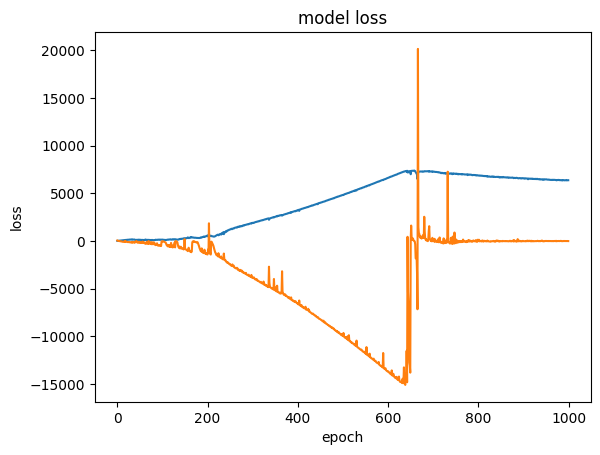

In [71]:
show_history(caries_wgan_history, "caries_WGAN")

In [72]:
gingivitis_wgan = build_model("gingivitis")
gingivitis_wgan_history = gingivitis_wgan.fit(gingivitis, epochs = 1000, batch_size = 50)
save_model(gingivitis_wgan, "gingivitis_WGAN")

Epoch 1/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 24s 24s/step - Discriminator Loss: 105.0619 - Generator Loss: 0.6606
Epoch 2/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - Discriminator Loss: 41.0831 - Generator Loss: 3.4916
Epoch 3/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - Discriminator Loss: -6.8938 - Generator Loss: 7.4135
Epoch 4/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - Discriminator Loss: -10.5010 - Generator Loss: 12.9140
Epoch 5/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - Discriminator Loss: -24.9103 - Generator Loss: 19.2797
Epoch 6/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - Discriminator Loss: -35.0342 - Generator Loss: 25.6065
Epoch 7/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - Discriminator Loss: -39.2962 - Generator Loss: 31.7647
Epoch 8/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - Discriminator Loss: -52.0428 - Generator Loss: 38.9106
Epoch 9/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - Discriminator Loss: -58.3819 - Generator Loss: 46.2108
Epoch 10/1000
1/1 ━━━━━━━

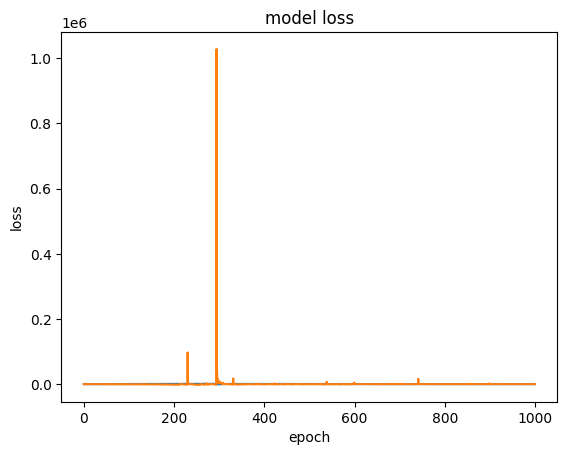

In [73]:
show_history(gingivitis_wgan_history, "gingivitis_WGAN")

In [74]:
wsl_wgan = build_model("wsl")
wsl_wgan_history = wsl_wgan.fit(wsl, epochs = 1000, batch_size = 50)
save_model(wsl_wgan, "wsl_WGAN")

Epoch 1/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 25s 25s/step - Discriminator Loss: 43.2270 - Generator Loss: 1.7380
Epoch 2/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - Discriminator Loss: 5.7929 - Generator Loss: 5.0294
Epoch 3/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - Discriminator Loss: -6.6579 - Generator Loss: 8.7934
Epoch 4/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - Discriminator Loss: -20.9032 - Generator Loss: 12.8402
Epoch 5/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - Discriminator Loss: -25.9665 - Generator Loss: 17.9971
Epoch 6/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - Discriminator Loss: -39.6319 - Generator Loss: 24.2998
Epoch 7/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - Discriminator Loss: -45.9090 - Generator Loss: 29.8346
Epoch 8/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - Discriminator Loss: -49.5177 - Generator Loss: 37.0096
Epoch 9/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - Discriminator Loss: -59.8307 - Generator Loss: 43.4757
Epoch 10/1000
1/1 ━━━━━━━━━

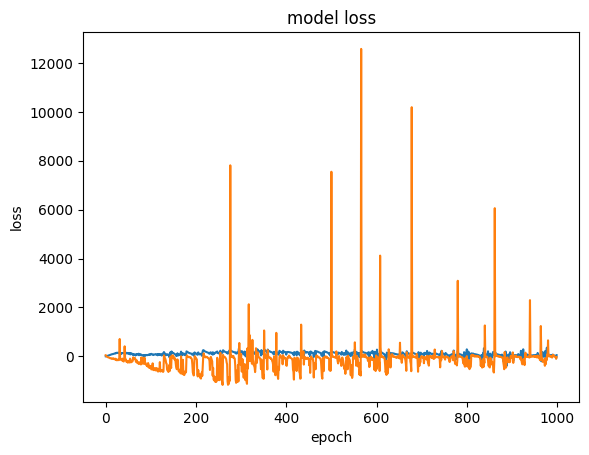

In [75]:
show_history(wsl_wgan_history, "wsl_WGAN")

1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/stepWARNING:tensorflow:6 out of the last 6 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x7fd9dae9e7a0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


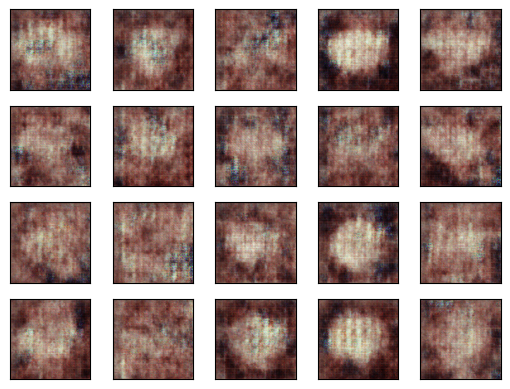

In [76]:
fixed_noise
y_pred = caries_wgan.generator.predict(fixed_noise)
show_images(y_pred)